In [1]:
import pandas as pd

In [2]:
df_final=pd.read_csv('df_final.csv')

In [3]:
df_final = df_final.drop(columns=['reggaeton', 'rock'])

In [4]:
df_final['Genero']

0              italian hip hop, italian pop, trap italiana
1                                                      NaN
2        ambient, braindance, electronica, intelligent ...
3                           jam band, neo mellow, pop rock
4                        argentine hip hop, trap argentino
                               ...                        
16861                                        j-pop, j-rock
16862                                                k-pop
16863                                    k-pop, korean r&b
16864                              k-pop, k-pop girl group
16865                                    k-pop, korean r&b
Name: Genero, Length: 16866, dtype: object

In [5]:
df_final['Stream'].describe()

count    1.686600e+04
mean     1.362465e+08
std      2.433885e+08
min      6.574000e+03
25%      1.748466e+07
50%      4.993142e+07
75%      1.391041e+08
max      3.386520e+09
Name: Stream, dtype: float64

In [7]:
# Agrupar por 'Genero' y contar el número de tracks
df_cluster_count = df_final.groupby('Cluster', as_index=False).size()

# Renombrar las columnas para mayor claridad
df_cluster_count.columns = ['Cluster', 'Num_Tracks']

# Ordenar por número de tracks en orden descendente
df_cluster_count = df_cluster_count.sort_values(by='Num_Tracks', ascending=False)

# Reiniciar el índice para un formato limpio
df_cluster_count.reset_index(drop=True, inplace=True)


In [8]:
df_cluster_count

,Cluster,Num_Tracks
0,1,12943
1,3,944
2,5,791
3,7,606
4,4,519
5,6,393
6,2,384
7,0,286


In [12]:
df_gen=df_final[df_final['Cluster'] ==3]

## Cálculo de quartiles del Stream

In [13]:
import pandas as pd

# Calcular los cuartiles
q1 = df_gen['Stream'].quantile(0.25)  # Primer cuartil (Q1)
q2 = df_gen['Stream'].quantile(0.50)  # Segundo cuartil (Q2) - Mediana
q3 = df_gen['Stream'].quantile(0.75)  # Tercer cuartil (Q3)

print(f"Q1: {q1}, Q2 (Mediana): {q2}, Q3: {q3}")


Q1: 43011346.25, Q2 (Mediana): 143343745.5, Q3: 348208764.75


Voy a dividir en dos categorias de stream. Una moderadamente extoso Stream menor a q3 y otra exitoso mayor a q3

In [14]:
# Definir los límites manualmente
bins = [0, q3, df_gen['Stream'].max()]
labels = [0,1]

df_gen['Categoria'] = pd.cut(df_gen['Stream'], bins=bins, labels=labels, include_lowest=True)
# Ver la distribución de las categorías
print(df_gen['Categoria'].value_counts())

Categoria
0    708
1    236
Name: count, dtype: int64


/tmp/ipykernel_406247/3106448690.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gen['Categoria'] = pd.cut(df_gen['Stream'], bins=bins, labels=labels, include_lowest=True)


La categorías estan algo desbalanceadas, para entrenar el modelo se va acotar el df de prueba. Solo se van a usar 4217 valores de la categoría cero

In [15]:
count_cat1=df_gen['Categoria'].value_counts()[1]

In [16]:
# Filtrar las categorías
categoria_0 = df_gen[df_gen['Categoria'] == 0]
categoria_1 = df_gen[df_gen['Categoria'] == 1]

# Muestrear 175 registros aleatorios de la categoría 0
categoria_0_sample = categoria_0.sample(n=count_cat1, random_state=42)

# Combinar los 175 registros de cada categoría
df_balanceado = pd.concat([categoria_0_sample, categoria_1])

# Barajar las filas (opcional, para mezclar las categorías)
df_balanceado = df_balanceado.sample(frac=1, random_state=42).reset_index(drop=True)

# Verificar la distribución de las categorías
print(df_balanceado['Categoria'].value_counts())

Categoria
0    236
1    236
Name: count, dtype: int64


In [17]:
X=df_balanceado[['Acousticness','Danceability', 'Duration_min', 'Energy',
       'Instrumentalness', 'Key', 'Liveness', 'Loudness',
       'Speechiness', 'Tempo', 'Valence',
        ]]

In [18]:
y=df_balanceado['Categoria']

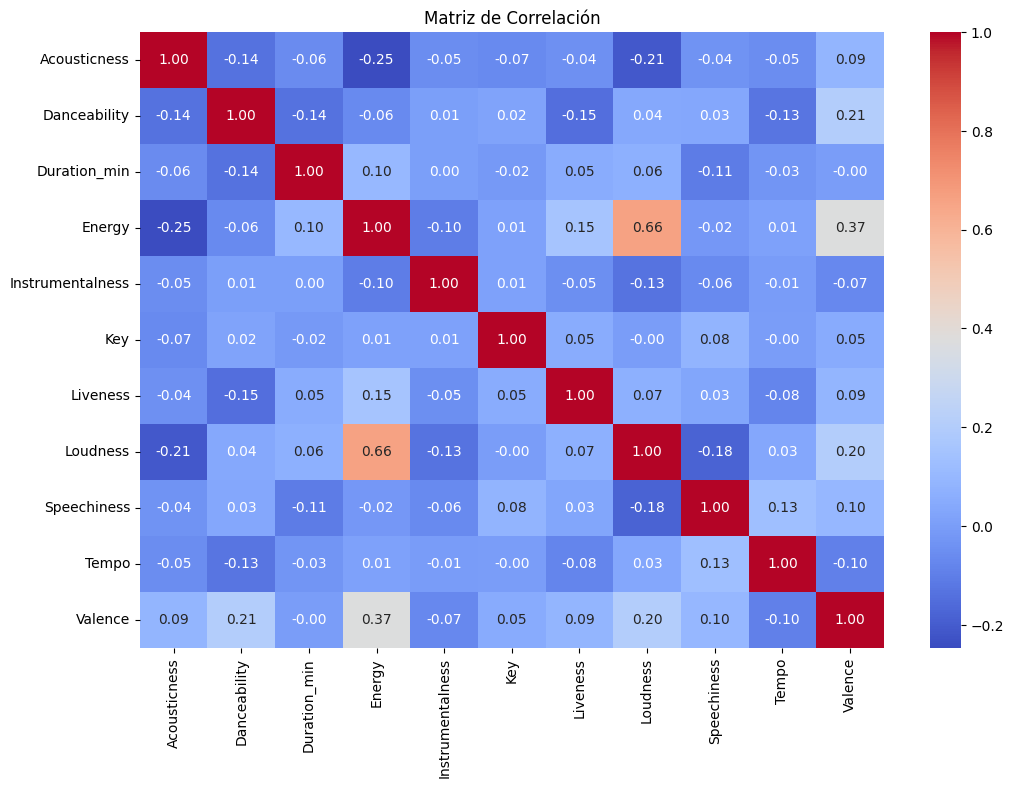

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Matriz de correlación
corr_matrix = X.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlación")
plt.show()

In [20]:
from sklearn.feature_selection import SelectKBest, f_classif

# Selecciona las 5 mejores características
selector = SelectKBest(score_func=f_classif, k=5)
X_new = selector.fit_transform(X, y)

# Nombres de las características seleccionadas
selected_features = X.columns[selector.get_support()]
print("Características seleccionadas:", selected_features)

Características seleccionadas: Index(['Acousticness', 'Instrumentalness', 'Liveness', 'Loudness',
       'Speechiness'],
      dtype='object')


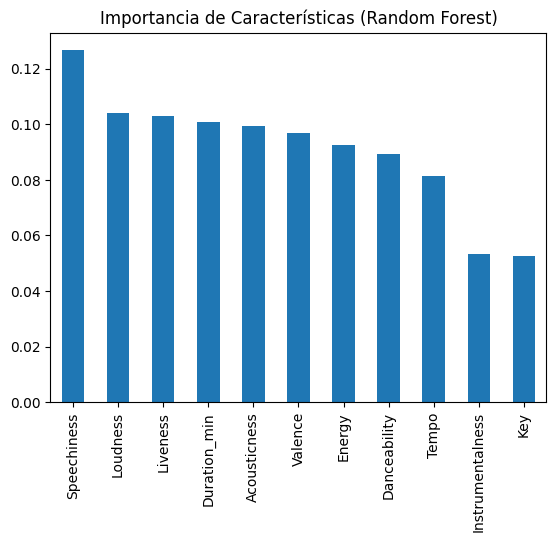

In [21]:
from sklearn.ensemble import RandomForestClassifier

# Entrenar modelo para obtener importancia de características
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

# Importancia
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).plot(kind='bar')
plt.title("Importancia de Características (Random Forest)")
plt.show()

In [22]:
from sklearn.model_selection import train_test_split, cross_val_score
# 🔹 2. Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
from lazypredict.Supervised import LazyClassifier

In [24]:
lazy_clf= LazyClassifier(verbose=0,
					ignore_warnings=False,
					custom_metric=None)

# fitting data in LazyClassifier
models, predictions = lazy_clf.fit(X_train, X_test,
							y_train, y_test)
models

 28%|██▊       | 9/32 [00:00<00:00, 28.11it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X).
FixedThresholdClassifier model failed to execute
FixedThresholdClassifier.__init__() missing 1 required positional argument: 'estimator'


100%|██████████| 32/32 [00:00<00:00, 33.54it/s]

SelfTrainingClassifier model failed to execute
You must pass an estimator to SelfTrainingClassifier. Use `estimator`.
StackingClassifier model failed to execute
StackingClassifier.__init__() missing 1 required positional argument: 'estimators'
TunedThresholdClassifierCV model failed to execute
TunedThresholdClassifierCV.__init__() missing 1 required positional argument: 'estimator'
XGBClassifier model failed to execute
'super' object has no attribute '__sklearn_tags__'
[LightGBM] [Info] Number of positive: 193, number of negative: 184
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1153
[LightGBM] [Info] Number of data points in the train set: 377, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511936 -> initscore=0.047754
[LightGBM] [Info] Start training from score 0.047754
[LightGBM] [Warning] No further splits w

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
SVC,0.68,0.69,0.69,0.68,0.01
Perceptron,0.67,0.68,0.68,0.67,0.01
PassiveAggressiveClassifier,0.66,0.67,0.67,0.66,0.02
NearestCentroid,0.65,0.66,0.66,0.65,0.01
RidgeClassifierCV,0.63,0.64,0.64,0.63,0.01
LogisticRegression,0.63,0.64,0.64,0.63,0.02
LinearDiscriminantAnalysis,0.63,0.64,0.64,0.63,0.02
LinearSVC,0.63,0.64,0.64,0.63,0.02
CalibratedClassifierCV,0.63,0.64,0.64,0.63,0.04


In [25]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Definir hiperparámetros a ajustar
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularización
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Tipo de núcleo
    'gamma': ['scale', 'auto'],  # Parámetro para RBF y Poly
}

# Configurar GridSearchCV
grid_search = GridSearchCV(
    SVC(),
    param_grid,
    scoring='f1_weighted',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Ajustar el modelo
grid_search.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros
print("Mejores parámetros:", grid_search.best_params_)

# Evaluar el mejor modelo
best_svc = grid_search.best_estimator_
y_pred = best_svc.predict(X_test)

from sklearn.metrics import classification_report
print("Reporte de Clasificación con SVC optimizado:")
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 32 candidates, totalling 160 fits
Mejores parámetros: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Reporte de Clasificación con SVC optimizado:
              precision    recall  f1-score   support

           0       0.75      0.58      0.65        52
           1       0.60      0.77      0.67        43

    accuracy                           0.66        95
   macro avg       0.68      0.67      0.66        95
weighted avg       0.68      0.66      0.66        95



In [49]:
cluster=4

In [51]:
df_gen=df_final[df_final['Cluster']==cluster]
        #df_gen.info()
        ## Cálculo de quartiles del Stream
        

        # Calcular los cuartiles
      
q3 = df_gen['Stream'].quantile(0.75)  # Tercer cuartil (Q3)

        #print(f"Q1: {q1}, Q2 (Mediana): {q2}, Q3: {q3}")

        #Voy a dividir en dos categorias de stream. Una moderadamente extoso Stream menor a q3 y otra exitoso mayor a q3
        # Definir los límites manualmente
        
bins = [0, q3, df_gen['Stream'].max()]
labels = [0,1]

df_gen['Categoria'] = pd.cut(df_gen['Stream'], bins=bins, labels=labels, include_lowest=True)
        # Ver la distribución de las categorías
        
        
count_cat1=df_gen['Categoria'].value_counts()[1]
        # Filtrar las categorías
categoria_0 = df_gen[df_gen['Categoria'] == 0]
categoria_1 = df_gen[df_gen['Categoria'] == 1]

        
categoria_0_sample = categoria_0.sample(n=count_cat1, random_state=42)

        
df_balanceado = pd.concat([categoria_0_sample, categoria_1])

        # Barajar las filas (opcional, para mezclar las categorías)
df_balanceado = df_balanceado.sample(frac=1, random_state=42).reset_index(drop=True)

In [52]:




        # Verificar la distribución de las categorías
        #print(f'valores por decada {decada}')
        #print(df_balanceado['Categoria'].value_counts())
        
X=df_balanceado[['Acousticness','Danceability', 'Duration_min', 'Energy',
        'Instrumentalness', 'Key', 'Liveness', 'Loudness',
        'Speechiness', 'Tempo', 'Valence',
                ]]
y=df_balanceado['Categoria']
from sklearn.model_selection import train_test_split, cross_val_score
        # 🔹 2. Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        
print(f'modelos cluster{cluster}')
        
from lazypredict.Supervised import LazyClassifier
lazy_clf= LazyClassifier(verbose=0,
                                                ignore_warnings=False,
                                                custom_metric=None)

        # fitting data in LazyClassifier
models, predictions = lazy_clf.fit(X_train, X_test,
                                                                y_train, y_test)
models
        


modelos cluster4


 34%|███▍      | 11/32 [00:00<00:00, 31.05it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X).
FixedThresholdClassifier model failed to execute
FixedThresholdClassifier.__init__() missing 1 required positional argument: 'estimator'


100%|██████████| 32/32 [00:00<00:00, 38.45it/s]

SelfTrainingClassifier model failed to execute
You must pass an estimator to SelfTrainingClassifier. Use `estimator`.
StackingClassifier model failed to execute
StackingClassifier.__init__() missing 1 required positional argument: 'estimators'
TunedThresholdClassifierCV model failed to execute
TunedThresholdClassifierCV.__init__() missing 1 required positional argument: 'estimator'
XGBClassifier model failed to execute
'super' object has no attribute '__sklearn_tags__'
[LightGBM] [Info] Number of positive: 101, number of negative: 107
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000038 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 661
[LightGBM] [Info] Number of data points in the train set: 208, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.485577 -> initscore=-0.057708
[LightGBM] [Info] Start training from score -0.057708
[LightGBM] [Warning] No further splits 

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
SGDClassifier,0.69,0.69,0.69,0.69,0.01
BernoulliNB,0.62,0.62,0.62,0.62,0.02
LogisticRegression,0.62,0.61,0.61,0.62,0.02
GaussianNB,0.58,0.59,0.59,0.57,0.01
LinearSVC,0.60,0.59,0.59,0.60,0.01
LinearDiscriminantAnalysis,0.60,0.59,0.59,0.60,0.01
RidgeClassifierCV,0.60,0.59,0.59,0.60,0.01
RidgeClassifier,0.60,0.59,0.59,0.60,0.01
CalibratedClassifierCV,0.58,0.57,0.57,0.57,0.05


In [67]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyClassifier

# Lista de clusters a evaluar
clusters = [0, 2, 3, 4, 5, 6, 7]

# Diccionario para almacenar resultados
test = {}

for cluster in clusters:
    # Filtrar por cluster y hacer una copia para evitar errores
    df_gen = df_final[df_final['Cluster'] == cluster].copy()

    # Calcular el tercer cuartil (Q3)
    q3 = df_gen['Stream'].quantile(0.75)

    # Definir las categorías
    bins = [0, q3, df_gen['Stream'].max()]
    labels = [0, 1]

    df_gen['Categoria'] = pd.cut(df_gen['Stream'], bins=bins, labels=labels, include_lowest=True)

    # Verificar si hay suficientes muestras en la categoría 1
    count_cat1 = df_gen['Categoria'].value_counts().get(1, 0)

    if count_cat1 == 0:
        print(f"⚠️ Cluster {cluster}: No hay suficientes muestras en la categoría 1, saltando...")
        continue

    # Filtrar por categorías
    categoria_0 = df_gen[df_gen['Categoria'] == 0]
    categoria_1 = df_gen[df_gen['Categoria'] == 1]

    # Muestrear la categoría 0 con el mismo número de elementos que la categoría 1
    categoria_0_sample = categoria_0.sample(n=min(count_cat1, len(categoria_0)), random_state=42)

    # Concatenar para obtener un dataset balanceado
    df_balanceado = pd.concat([categoria_0_sample, categoria_1]).sample(frac=1, random_state=42).reset_index(drop=True)

    # Definir variables predictoras y objetivo
    X = df_balanceado[['Acousticness', 'Danceability', 'Duration_min', 'Energy',
                       'Instrumentalness', 'Key', 'Liveness', 'Loudness',
                       'Speechiness', 'Tempo', 'Valence']]
    y = df_balanceado['Categoria']

    # Dividir en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Evaluación con LazyClassifier
    lazy_clf = LazyClassifier(verbose=0, ignore_warnings=False, custom_metric=None)
    models, predictions = lazy_clf.fit(X_train, X_test, y_train, y_test)

    # Guardar resultados en el diccionario
    test[cluster] = models

print("✅ Evaluación completada para todos los clusters.")


 28%|██▊       | 9/32 [00:00<00:00, 27.28it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X).
FixedThresholdClassifier model failed to execute
FixedThresholdClassifier.__init__() missing 1 required positional argument: 'estimator'


100%|██████████| 32/32 [00:00<00:00, 35.79it/s]


SelfTrainingClassifier model failed to execute
You must pass an estimator to SelfTrainingClassifier. Use `estimator`.
StackingClassifier model failed to execute
StackingClassifier.__init__() missing 1 required positional argument: 'estimators'
TunedThresholdClassifierCV model failed to execute
TunedThresholdClassifierCV.__init__() missing 1 required positional argument: 'estimator'
XGBClassifier model failed to execute
'super' object has no attribute '__sklearn_tags__'
[LightGBM] [Info] Number of positive: 60, number of negative: 55
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 381
[LightGBM] [Info] Number of data points in the train set: 115, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.521739 -> initscore=0.087011
[LightGBM] [Info] Start training from score 0.087011
[LightGBM] [Warning] No further splits with

 28%|██▊       | 9/32 [00:00<00:00, 26.02it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X).
FixedThresholdClassifier model failed to execute
FixedThresholdClassifier.__init__() missing 1 required positional argument: 'estimator'


 72%|███████▏  | 23/32 [00:00<00:00, 23.55it/s]

SelfTrainingClassifier model failed to execute
You must pass an estimator to SelfTrainingClassifier. Use `estimator`.
StackingClassifier model failed to execute
StackingClassifier.__init__() missing 1 required positional argument: 'estimators'
TunedThresholdClassifierCV model failed to execute
TunedThresholdClassifierCV.__init__() missing 1 required positional argument: 'estimator'
XGBClassifier model failed to execute
'super' object has no attribute '__sklearn_tags__'


100%|██████████| 32/32 [00:01<00:00, 26.02it/s]


[LightGBM] [Info] Number of positive: 79, number of negative: 74
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 487
[LightGBM] [Info] Number of data points in the train set: 153, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.516340 -> initscore=0.065383
[LightGBM] [Info] Start training from score 0.065383
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

 28%|██▊       | 9/32 [00:00<00:00, 24.65it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X).
FixedThresholdClassifier model failed to execute
FixedThresholdClassifier.__init__() missing 1 required positional argument: 'estimator'


100%|██████████| 32/32 [00:01<00:00, 31.98it/s]


SelfTrainingClassifier model failed to execute
You must pass an estimator to SelfTrainingClassifier. Use `estimator`.
StackingClassifier model failed to execute
StackingClassifier.__init__() missing 1 required positional argument: 'estimators'
TunedThresholdClassifierCV model failed to execute
TunedThresholdClassifierCV.__init__() missing 1 required positional argument: 'estimator'
XGBClassifier model failed to execute
'super' object has no attribute '__sklearn_tags__'
[LightGBM] [Info] Number of positive: 193, number of negative: 184
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1153
[LightGBM] [Info] Number of data points in the train set: 377, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511936 -> initscore=0.047754
[LightGBM] [Info] Start training from score 0.047754
[LightGBM] [Warning] No further splits w

 28%|██▊       | 9/32 [00:00<00:00, 25.52it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X).
FixedThresholdClassifier model failed to execute
FixedThresholdClassifier.__init__() missing 1 required positional argument: 'estimator'


100%|██████████| 32/32 [00:00<00:00, 35.30it/s]


SelfTrainingClassifier model failed to execute
You must pass an estimator to SelfTrainingClassifier. Use `estimator`.
StackingClassifier model failed to execute
StackingClassifier.__init__() missing 1 required positional argument: 'estimators'
TunedThresholdClassifierCV model failed to execute
TunedThresholdClassifierCV.__init__() missing 1 required positional argument: 'estimator'
XGBClassifier model failed to execute
'super' object has no attribute '__sklearn_tags__'
[LightGBM] [Info] Number of positive: 101, number of negative: 107
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 661
[LightGBM] [Info] Number of data points in the train set: 208, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.485577 -> initscore=-0.057708
[LightGBM] [Info] Start training from score -0.057708
[LightGBM] [Warning] No further splits 

 28%|██▊       | 9/32 [00:00<00:00, 26.33it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X).
FixedThresholdClassifier model failed to execute
FixedThresholdClassifier.__init__() missing 1 required positional argument: 'estimator'


100%|██████████| 32/32 [00:00<00:00, 35.06it/s]


SelfTrainingClassifier model failed to execute
You must pass an estimator to SelfTrainingClassifier. Use `estimator`.
StackingClassifier model failed to execute
StackingClassifier.__init__() missing 1 required positional argument: 'estimators'
TunedThresholdClassifierCV model failed to execute
TunedThresholdClassifierCV.__init__() missing 1 required positional argument: 'estimator'
XGBClassifier model failed to execute
'super' object has no attribute '__sklearn_tags__'
[LightGBM] [Info] Number of positive: 163, number of negative: 153
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1005
[LightGBM] [Info] Number of data points in the train set: 316, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.515823 -> initscore=0.063312
[LightGBM] [Info] Start training from score 0.063312
[LightGBM] [Warning] No further splits w

 38%|███▊      | 12/32 [00:00<00:00, 35.15it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X).
FixedThresholdClassifier model failed to execute
FixedThresholdClassifier.__init__() missing 1 required positional argument: 'estimator'


100%|██████████| 32/32 [00:00<00:00, 36.21it/s]


SelfTrainingClassifier model failed to execute
You must pass an estimator to SelfTrainingClassifier. Use `estimator`.
StackingClassifier model failed to execute
StackingClassifier.__init__() missing 1 required positional argument: 'estimators'
TunedThresholdClassifierCV model failed to execute
TunedThresholdClassifierCV.__init__() missing 1 required positional argument: 'estimator'
XGBClassifier model failed to execute
'super' object has no attribute '__sklearn_tags__'
[LightGBM] [Info] Number of positive: 77, number of negative: 79
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 517
[LightGBM] [Info] Number of data points in the train set: 156, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493590 -> initscore=-0.025642
[LightGBM] [Info] Start training from score -0.025642
[LightGBM] [Warning] No further splits wi

 28%|██▊       | 9/32 [00:00<00:00, 29.13it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X).
FixedThresholdClassifier model failed to execute
FixedThresholdClassifier.__init__() missing 1 required positional argument: 'estimator'


100%|██████████| 32/32 [00:00<00:00, 35.58it/s]

SelfTrainingClassifier model failed to execute
You must pass an estimator to SelfTrainingClassifier. Use `estimator`.
StackingClassifier model failed to execute
StackingClassifier.__init__() missing 1 required positional argument: 'estimators'
TunedThresholdClassifierCV model failed to execute
TunedThresholdClassifierCV.__init__() missing 1 required positional argument: 'estimator'
XGBClassifier model failed to execute
'super' object has no attribute '__sklearn_tags__'
[LightGBM] [Info] Number of positive: 118, number of negative: 125
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 756
[LightGBM] [Info] Number of data points in the train set: 243, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.485597 -> initscore=-0.057629
[LightGBM] [Info] Start training from score -0.057629
[LightGBM] [Warning] No further splits 

In [72]:
for i in test.keys():
    print(f'Modelos del cluster {i}')
    display(test[i])  # Esto imprimirá los resultados de LazyClassifier


Modelos del cluster 0


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
ExtraTreesClassifier,0.69,0.70,0.70,0.69,0.10
BaggingClassifier,0.66,0.66,0.66,0.66,0.04
RidgeClassifier,0.62,0.65,0.65,0.61,0.02
LogisticRegression,0.62,0.65,0.65,0.61,0.02
LinearDiscriminantAnalysis,0.62,0.65,0.65,0.61,0.02
RidgeClassifierCV,0.62,0.65,0.65,0.61,0.02
LinearSVC,0.62,0.65,0.65,0.61,0.01
DecisionTreeClassifier,0.62,0.64,0.64,0.62,0.02
CalibratedClassifierCV,0.55,0.62,0.62,0.49,0.05


Modelos del cluster 2


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
RandomForestClassifier,0.69,0.69,0.69,0.69,0.18
ExtraTreesClassifier,0.67,0.68,0.68,0.66,0.10
LabelPropagation,0.64,0.67,0.67,0.63,0.02
LabelSpreading,0.64,0.67,0.67,0.63,0.03
AdaBoostClassifier,0.64,0.64,0.64,0.64,0.14
CalibratedClassifierCV,0.62,0.63,0.63,0.61,0.04
LinearDiscriminantAnalysis,0.62,0.63,0.63,0.61,0.03
RidgeClassifier,0.62,0.63,0.63,0.61,0.01
RidgeClassifierCV,0.62,0.63,0.63,0.61,0.02


Modelos del cluster 3


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
SVC,0.68,0.69,0.69,0.68,0.02
Perceptron,0.67,0.68,0.68,0.67,0.02
PassiveAggressiveClassifier,0.66,0.67,0.67,0.66,0.02
NearestCentroid,0.65,0.66,0.66,0.65,0.02
RidgeClassifierCV,0.63,0.64,0.64,0.63,0.01
LogisticRegression,0.63,0.64,0.64,0.63,0.02
LinearDiscriminantAnalysis,0.63,0.64,0.64,0.63,0.02
LinearSVC,0.63,0.64,0.64,0.63,0.02
CalibratedClassifierCV,0.63,0.64,0.64,0.63,0.03


Modelos del cluster 4


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
SGDClassifier,0.69,0.69,0.69,0.69,0.01
BernoulliNB,0.62,0.62,0.62,0.62,0.02
LogisticRegression,0.62,0.61,0.61,0.62,0.02
GaussianNB,0.58,0.59,0.59,0.57,0.01
LinearSVC,0.60,0.59,0.59,0.60,0.02
LinearDiscriminantAnalysis,0.60,0.59,0.59,0.60,0.02
RidgeClassifierCV,0.60,0.59,0.59,0.60,0.01
RidgeClassifier,0.60,0.59,0.59,0.60,0.01
CalibratedClassifierCV,0.58,0.57,0.57,0.57,0.04


Modelos del cluster 5


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LinearDiscriminantAnalysis,0.70,0.72,0.72,0.70,0.02
LinearSVC,0.70,0.72,0.72,0.70,0.01
RidgeClassifier,0.70,0.72,0.72,0.70,0.01
LogisticRegression,0.69,0.71,0.71,0.68,0.04
RidgeClassifierCV,0.68,0.69,0.69,0.67,0.01
CalibratedClassifierCV,0.62,0.66,0.66,0.60,0.04
QuadraticDiscriminantAnalysis,0.64,0.65,0.65,0.64,0.01
SVC,0.61,0.63,0.63,0.61,0.01
PassiveAggressiveClassifier,0.56,0.60,0.60,0.51,0.02


Modelos del cluster 6


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
DecisionTreeClassifier,0.55,0.55,0.55,0.55,0.01
LGBMClassifier,0.53,0.53,0.53,0.52,0.03
LabelPropagation,0.53,0.53,0.53,0.53,0.01
LabelSpreading,0.53,0.53,0.53,0.53,0.01
KNeighborsClassifier,0.53,0.52,0.52,0.51,0.01
BaggingClassifier,0.50,0.50,0.50,0.50,0.04
NearestCentroid,0.50,0.50,0.50,0.50,0.01
DummyClassifier,0.47,0.50,0.50,0.31,0.01
NuSVC,0.50,0.50,0.50,0.50,0.02


Modelos del cluster 7


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
SVC,0.66,0.65,0.65,0.65,0.02
ExtraTreesClassifier,0.62,0.62,0.62,0.62,0.10
ExtraTreeClassifier,0.61,0.61,0.61,0.61,0.01
SGDClassifier,0.61,0.60,0.60,0.60,0.01
DecisionTreeClassifier,0.59,0.59,0.59,0.59,0.01
NuSVC,0.59,0.59,0.59,0.59,0.02
RandomForestClassifier,0.59,0.59,0.59,0.59,0.14
QuadraticDiscriminantAnalysis,0.61,0.58,0.58,0.58,0.02
LGBMClassifier,0.59,0.58,0.58,0.58,0.03


In [64]:
a

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
SVC,0.66,0.65,0.65,0.65,0.02
ExtraTreesClassifier,0.62,0.62,0.62,0.62,0.10
ExtraTreeClassifier,0.61,0.61,0.61,0.61,0.02
SGDClassifier,0.61,0.60,0.60,0.60,0.02
DecisionTreeClassifier,0.59,0.59,0.59,0.59,0.02
NuSVC,0.59,0.59,0.59,0.59,0.02
RandomForestClassifier,0.59,0.59,0.59,0.59,0.14
QuadraticDiscriminantAnalysis,0.61,0.58,0.58,0.58,0.02
LGBMClassifier,0.59,0.58,0.58,0.58,0.03


In [ ]:
# Crear el modelo con los mejores parámetros
        rf_optimized = RandomForestClassifier(
        class_weight=None, 
        max_depth=5, 
        max_features='sqrt', 
        min_samples_leaf=1, 
        min_samples_split=10, 
        n_estimators=200, 
        random_state=42
        )

        # Entrenar el modelo con los datos de entrenamiento
        rf_optimized.fit(X_train, y_train)

        # Predecir las clases en el conjunto de prueba
        y_pred = rf_optimized.predict(X_test)

        # Reporte de clasificación
        print(f"Reporte de Clasificación para Random Forest Optimizado cluster {cluster}:")
        print(classification_report(y_test, y_pred))

        # Matriz de confusión
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title("Matriz de Confusión para Random Forest Optimizado cluster {cluster}")
        plt.xlabel("Predicción")
        plt.ylabel("Verdadero")
        plt.show()